<a href="https://colab.research.google.com/github/aharshit123456/ddpm/blob/main/ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDPM Notebook

Datasets used from torchvision of CIFAR10

## AE

## VAE

## reverse
## forward
## loss

## Scheduler

In [3]:
## Scheduler
'''
sequentially add noise to images
precomputed values used
'''


import torch.nn.functional as F
import torch

def get_index_from_list(vals, t, x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,)* (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumulative_products_t = get_index_from_list(sqrt_alphas_cumulative_products, t, x_0.shape)
  sqrt_one_minus_alphas_cumulative_products_t = get_index_from_list(
      sqrt_one_minus_alphas_cumulative_products, t, x_0.shape
  )
  ## formulae for image augged looks like sqrt(pi(alpha_t)) * x_t-1 * sqrt(pi(1-alpha_t)) * noise~N(0,1)
  return sqrt_alphas_cumulative_products_t.to(device) * x_0.to(device) \
      + sqrt_one_minus_alphas_cumulative_products_t.to(device) * noise.to(device), noise.to(device)

In [4]:
T = 300 ## according to the paper

### SOO MMANNYY PRECOMPUTEDD VALUESS TO TRACKKKK
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_cumulative_products = torch.cumprod(alphas, axis=0)
alphas_cumulative_products_prev = F.pad(alphas_cumulative_products[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumulative_products = torch.sqrt(alphas_cumulative_products)
sqrt_one_minus_alphas_cumulative_products = torch.sqrt(1. - alphas_cumulative_products)
## in paper its B * (1 - pi(alphas_(t-1)) / (1 - pi(alphas_t))
posterior_variance = betas * (1. - alphas_cumulative_products_prev) / (1. - alphas_cumulative_products)

## Dataloader
load the dataset, sample tensor images, yada yada crap

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Subset


IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # Define the transformation pipeline
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    # Load CIFAR10 dataset without splitting
    cifar10_dataset = torchvision.datasets.CIFAR10(root=".", download=True, transform=data_transform)

    # Split indices into train and test using sklearn's train_test_split
    dataset_size = len(cifar10_dataset)
    indices = list(range(dataset_size))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Create train and test subsets
    train_subset = Subset(cifar10_dataset, train_indices)
    test_subset = Subset(cifar10_dataset, test_indices)

    # Combine train and test subsets into a single ConcatDataset
    combined_dataset = torch.utils.data.ConcatDataset([train_subset, test_subset])

    return combined_dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 170M/170M [00:04<00:00, 38.0MB/s]


Extracting ./cifar-10-python.tar.gz to .


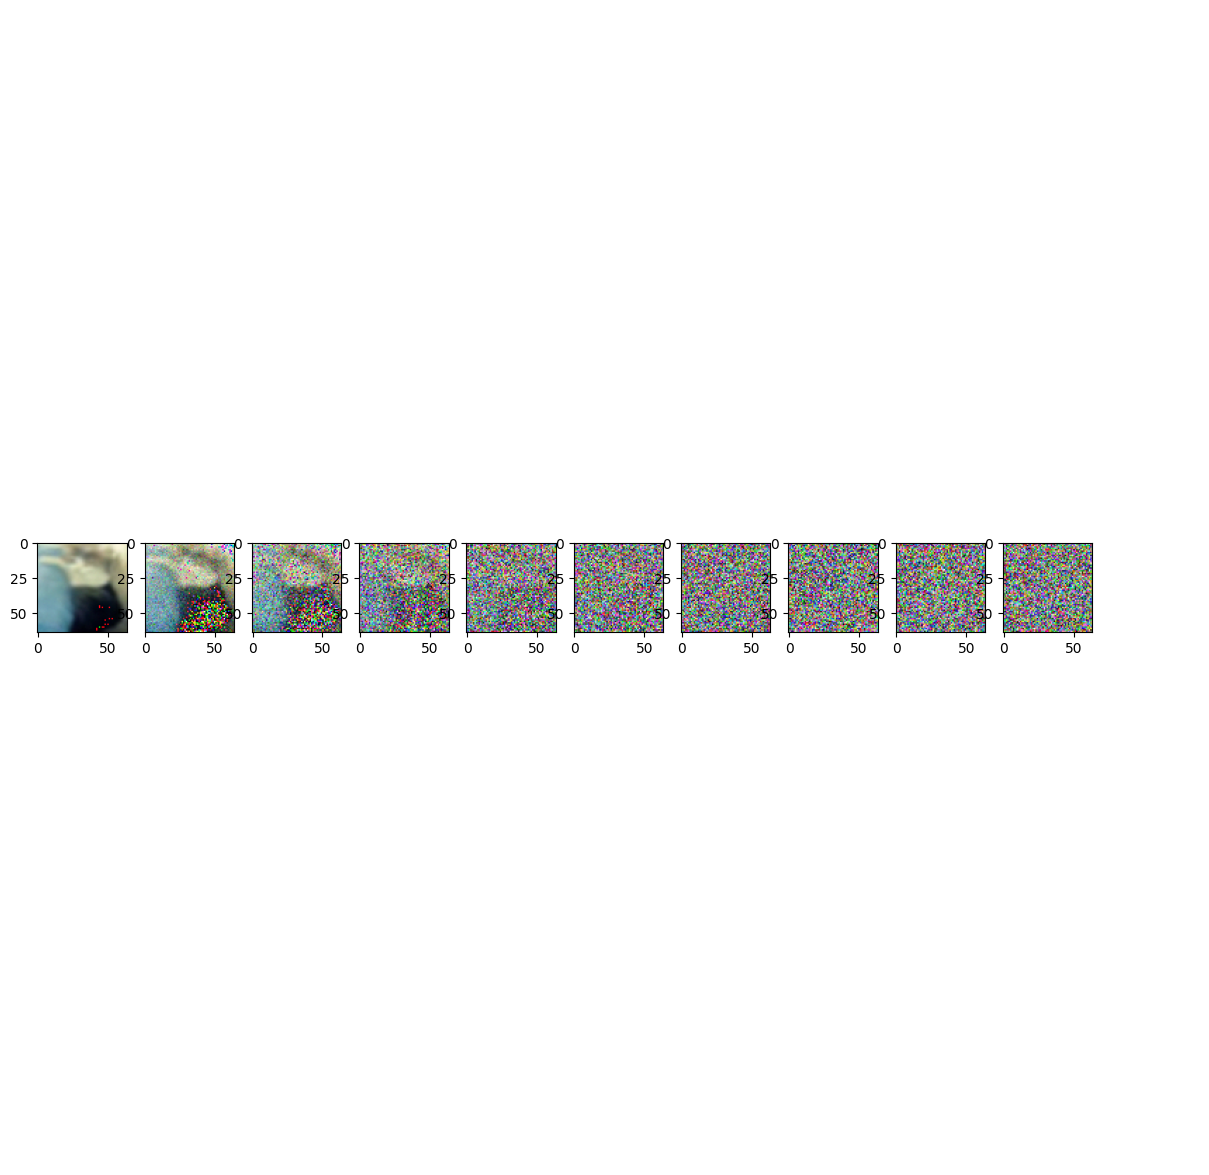

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Sampling (from Algorithm 2)


*  sample some noise
- from T to 1 we sample z from N(0,1), denoise the image progressively.
-


In [24]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumulative_products_t = get_index_from_list(
        sqrt_one_minus_alphas_cumulative_products, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumulative_products_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## UNET FOR REVERSE

1. UNET from OG PAPER!! to Predict noise instead of segmentation mask
2. Add timestep encoding to the UNET model
3. mean output (fixed variance)


<!-- variance can also be reparameterized and added on as a parameter but for simplicity, variance is fixed. -->

In [8]:
from torch import nn
import math

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    if up:
      ## up channel - go big big big bigg from smol smol smol with 3x3 kernel
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4,2,1)
    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.relu = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm2d(out_ch)
    self.batch_norm2 = nn.BatchNorm2d(out_ch)

  def forward(self, x, t, ):
    h = self.batch_norm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    time_emb = time_emb[(..., ) + (None, ) * 2]
    h = h + time_emb
    h = self.batch_norm2(self.relu(self.conv2(h)))
    return self.transform(h)

In [ ]:
from torch import nn
import math

class Block_CBAM(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    if up:
      ## up channel - go big big big bigg from smol smol smol with 3x3 kernel
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4,2,1)

    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.relu = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm2d(out_ch)
    self.batch_norm2 = nn.BatchNorm2d(out_ch)

    self.cbam = CBAM(out_ch)

  def forward(self, x, t, ):
    h = self.batch_norm1(self.relu(self.conv1(x)))
    time_emb = self.relu(self.time_mlp(t))
    time_emb = time_emb[(..., ) + (None, ) * 2]
    h = h + time_emb
    h = self.batch_norm2(self.relu(self.conv2(h)))

    h = self.cbam(h)
    return self.transform(h)

In [ ]:
class ResDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=2)  # Downsample

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = self.norm(x)
        x = F.gelu(self.conv2(x))
        return x


In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, chs,context_dim, num_heads):
    super().__init__()
    self.norm_x = nn.LayerNorm(chs)
    self.norm_context = nn.LayerNorm(context_dim)

    self,attn = nn.MultiheadAttention(embed_dim=chs, num_heads=num_heads, batch_first=True)
    self.fc = nn.Linear(context_dim, chs)

  def forward(self, x, context):
    b,c,h,w = x.shape
    x_reshaped = x.view(b,c,h*w).transpose(1,2)
    context = self.fc(self.norm_context(context))

    x_attn, _ = self.attn(self.norm_x(x_reshaped),context, context)

    x_attn = x_attn.transpose(1,2).view(b,c,h,w)

    return x + x_attn

In [26]:
class SelfAttention(nn.Module):
  def __init__(self, chs, num_heads=1, ffn_expansion=4, dropout=0.1):
    super().__init__()
    self.norm = nn.LayerNorm(chs)
    self.attn = nn.MultiheadAttention(embed_dim=chs, num_heads=num_heads, batch_first=True)

    self.ffn = nn.Sequential(
        nn.Linear(chs, chs*ffn_expansion),
        nn.GELU(),
        nn.Linear(chs*ffn_expansion, chs)
    )

    self.norm2 = nn.LayerNorm(chs)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    b,c,h,w = x.shape
    x_reshaped = x.view(b,c,h*w).transpose(1,2)

    attn_out, _ = self.attn(self.norm(x_reshaped), self.norm(x_reshaped), self.norm(x_reshaped))
    x_attn = x_reshaped + self.dropout(attn_out)

    ffn_out = self.ffn(self.norm2(x_attn))
    x_out = x_attn + self.dropout(ffn_out)


    x_out = x_out.transpose(1,2).view(b,c,h,w)
    return x_out

In [ ]:
class CBAM(nn.Module):
  def __init__(self,chs, reduction=16):
    super().__init__()

    self.channel_attn = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(chs, chs//reduction, 1),
        nn.ReLU(),
        nn.Conv2d(chs//reduction, chs, 1),
        nn.Sigmoid()
    )

    self.spatial_attn = nn.Sequential(
        nn.Conv2d(2,1,kernel_size=7,padding=3),
        nn.Sigmoid()
    )

  def forward(self,x):
    ch_wt = self.channel_attn(x)
    x = x*ch_wt

    avg_pool = torch.mean(x, dim=1, keepdim=True)
    max_pool, _ = torch.max(x, dim=1, keepdim=True)
    sp_wt = self.spatial_attn(torch.cat([avg_pool, max_pool], dim=1))
    x = x* sp_wt

    return x

In [18]:
class PositionEmbeddings(nn.Module):
  def __init__(self,dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [19]:
class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)

    out_dim = 3
    time_emb_dim = 32

    ## timestep stored as positional encoding in terms of sine
    self.time_mlp = nn.Sequential(
        PositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )
    self.num_timesteps = 300


    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
    self.down_blocks = nn.ModuleList([
        Block(down_channels[i], down_channels[i+1], time_emb_dim)
        for i in range(len(down_channels)-1)
    ])
    self.up_blocks = nn.ModuleList([
        Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
        for i in range(len(up_channels)-1)
    ])

    ## readout layer
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
  # def settimestep()

  def forward(self, x, timestep):
    self.num_timesteps = timestep
    t = self.time_mlp(timestep)
    x = self.conv0(x)
    residual_inputs = []
    for down in self.down_blocks:
      x = down(x, t)
      residual_inputs.append(x)
    for up in self.up_blocks:
      residual_x = residual_inputs.pop()
      x = torch.cat((x, residual_x), dim=1)
      x = up(x, t)
    return self.output(x)

  @torch.no_grad()
  def sample(self, noise):
      """
      Generate an image by denoising a given noise tensor using the reverse diffusion process.

      Args:
          noise (torch.Tensor): Initial noise tensor (e.g., sampled from a Gaussian distribution).

      Returns:
          torch.Tensor: Denoised image.
      """
      img = noise  # Start with the provided noise tensor
      T = self.num_timesteps  # Total timesteps for diffusion
      stepsize = 1  # You can adjust if needed
      print(noise.device)

      # Iterate through the timesteps in reverse order
      for i in range(T - 1, -1, -1):
          t = torch.full((noise.size(0),), i, device=noise.device, dtype=torch.long)  # Current timestep
          img = sample_timestep(self, img, t)  # Perform one reverse diffusion step
          img = torch.clamp(img, -1.0, 1.0)  # Clamp the image to ensure values stay in [-1, 1]

      return img

In [27]:
class SimpleUnetWAttn(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)

    out_dim = 3
    time_emb_dim = 32

    ## timestep stored as positional encoding in terms of sine
    self.time_mlp = nn.Sequential(
        PositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )
    self.num_timesteps = 300


    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
    self.down_blocks = nn.ModuleList([
        Block(down_channels[i], down_channels[i+1], time_emb_dim)
        for i in range(len(down_channels)-1)
    ])
    self.up_blocks = nn.ModuleList([
        Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
        for i in range(len(up_channels)-1)
    ])

    self.self_attention = SelfAttention(down_channels[-1])


    ## readout layer
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)


  # def settimestep()

  def forward(self, x, timestep):
    self.num_timesteps = timestep
    t = self.time_mlp(timestep)
    x = self.conv0(x)
    residual_inputs = []
    for down in self.down_blocks:
      x = down(x, t)
      residual_inputs.append(x)

    x = self.self_attention(x)

    for up in self.up_blocks:
      residual_x = residual_inputs.pop()
      x = torch.cat((x, residual_x), dim=1)
      x = up(x, t)
    return self.output(x)

  @torch.no_grad()
  def sample(self, noise):
      """
      Generate an image by denoising a given noise tensor using the reverse diffusion process.

      Args:
          noise (torch.Tensor): Initial noise tensor (e.g., sampled from a Gaussian distribution).

      Returns:
          torch.Tensor: Denoised image.
      """
      img = noise  # Start with the provided noise tensor
      T = self.num_timesteps  # Total timesteps for diffusion
      stepsize = 1  # You can adjust if needed
      print(noise.device)

      # Iterate through the timesteps in reverse order
      for i in range(T - 1, -1, -1):
          t = torch.full((noise.size(0),), i, device=noise.device, dtype=torch.long)  # Current timestep
          img = sample_timestep(self, img, t)  # Perform one reverse diffusion step
          img = torch.clamp(img, -1.0, 1.0)  # Clamp the image to ensure values stay in [-1, 1]

      return img

In [28]:
model = SimpleUnetWAttn()
print(model)

SimpleUnetWAttn(
  (time_mlp): Sequential(
    (0): PositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [22]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Traning loop

- sampling from dataset
- random t
- sample noise
- gradient descent of the model prediction on an image with sample noise added to predict the sample noise added
- repeat until convergence


Epoch 0 | step 000 Loss: 0.8106462359428406 


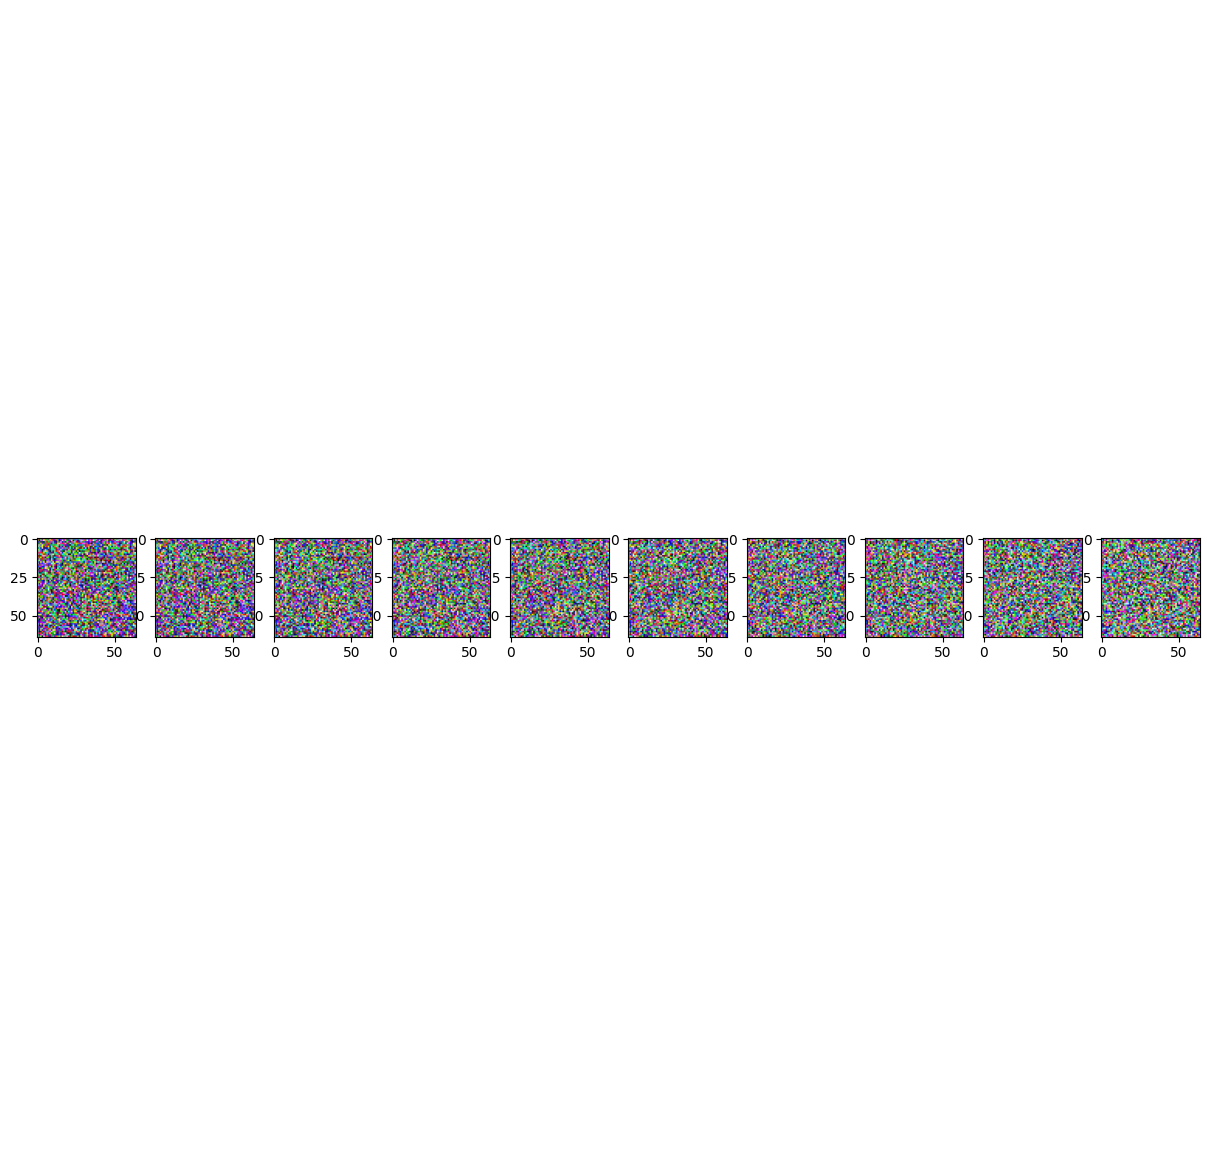

Epoch 0 | step 150 Loss: 0.7240776419639587 


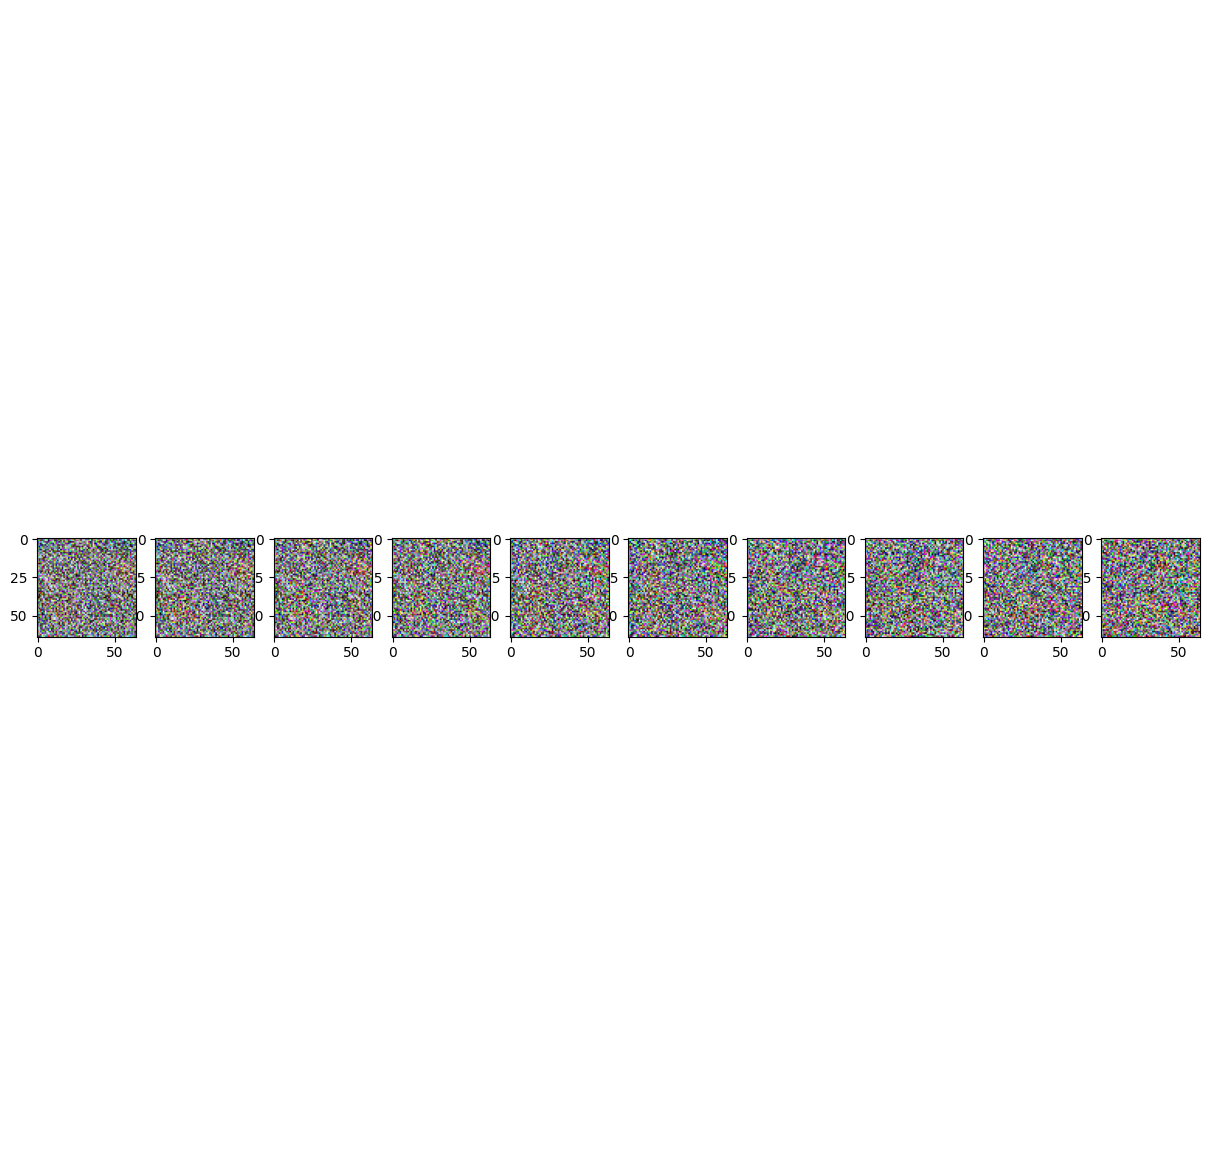

Epoch 0 | step 300 Loss: 0.3645506799221039 


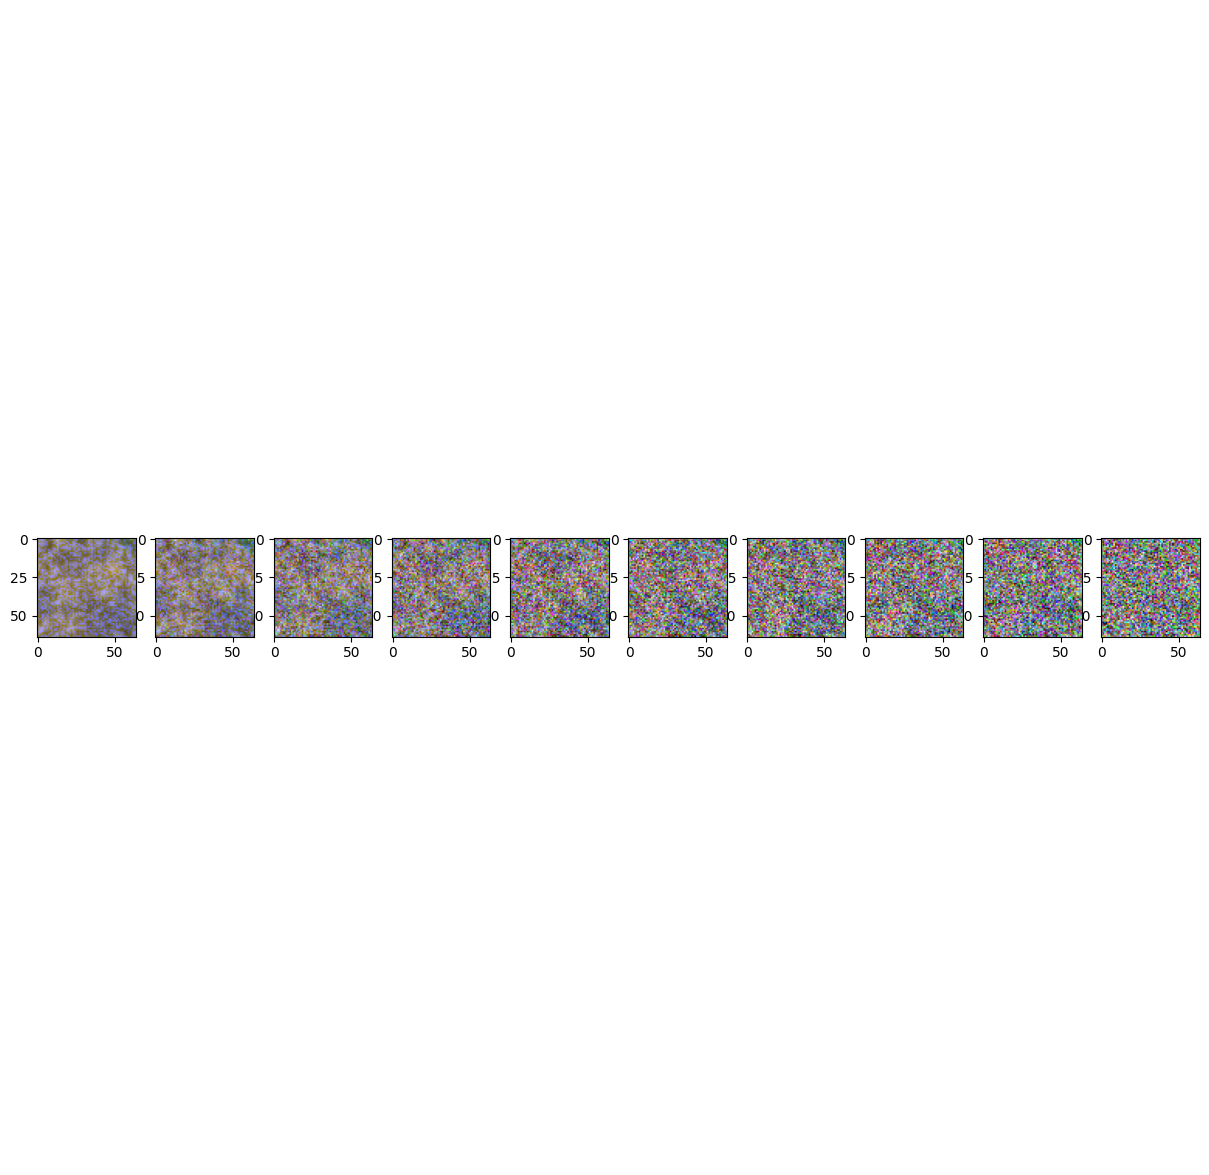

Epoch 1 | step 000 Loss: 0.3575814962387085 


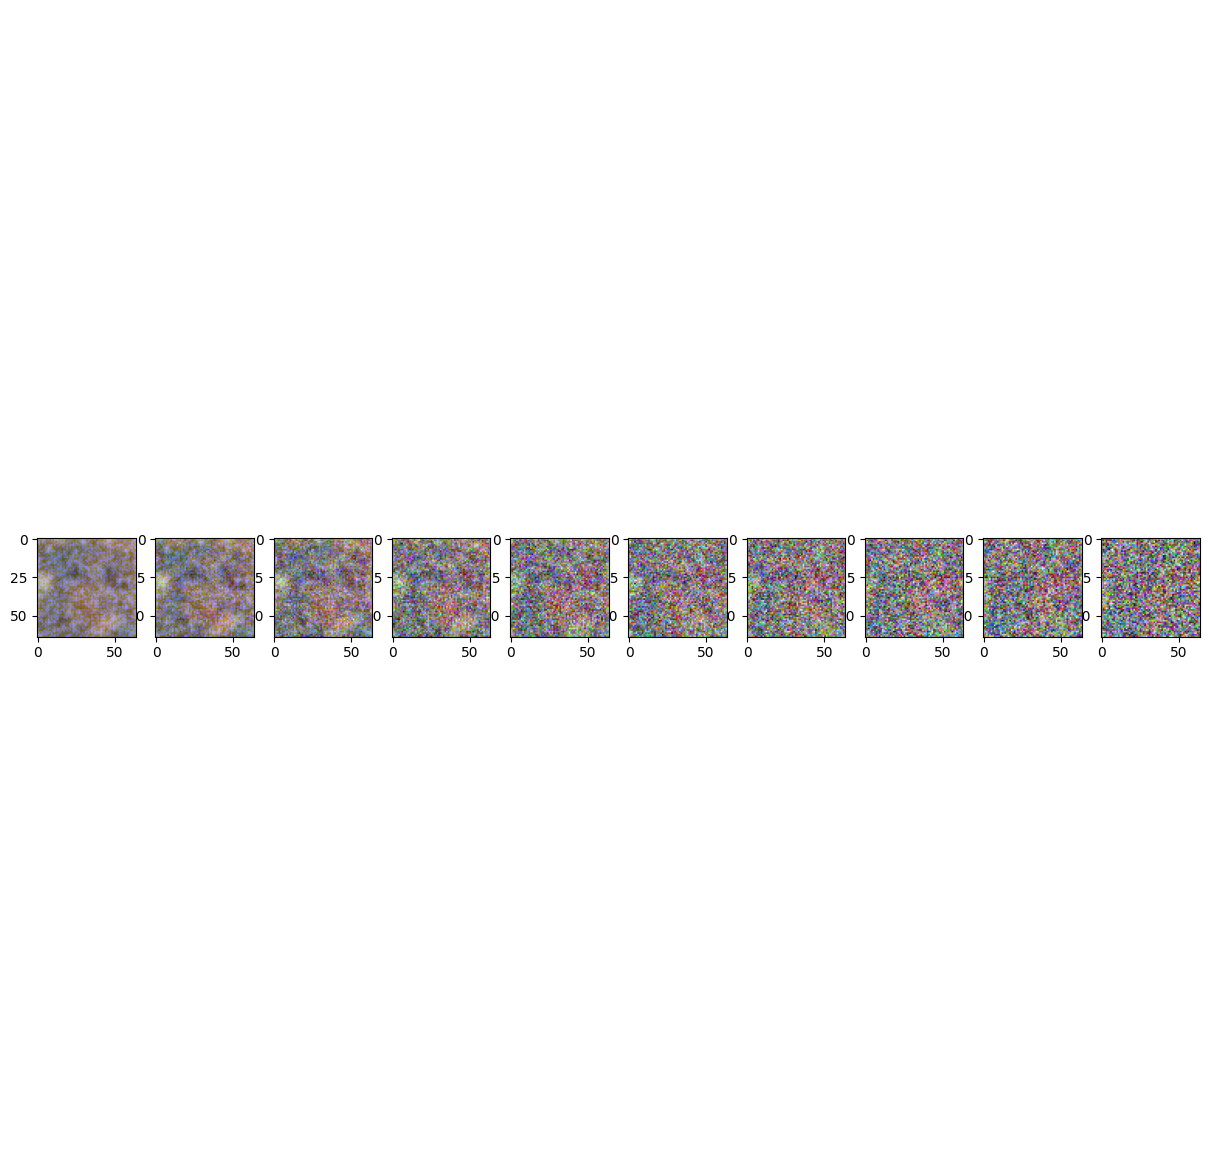

Epoch 1 | step 150 Loss: 0.34400033950805664 


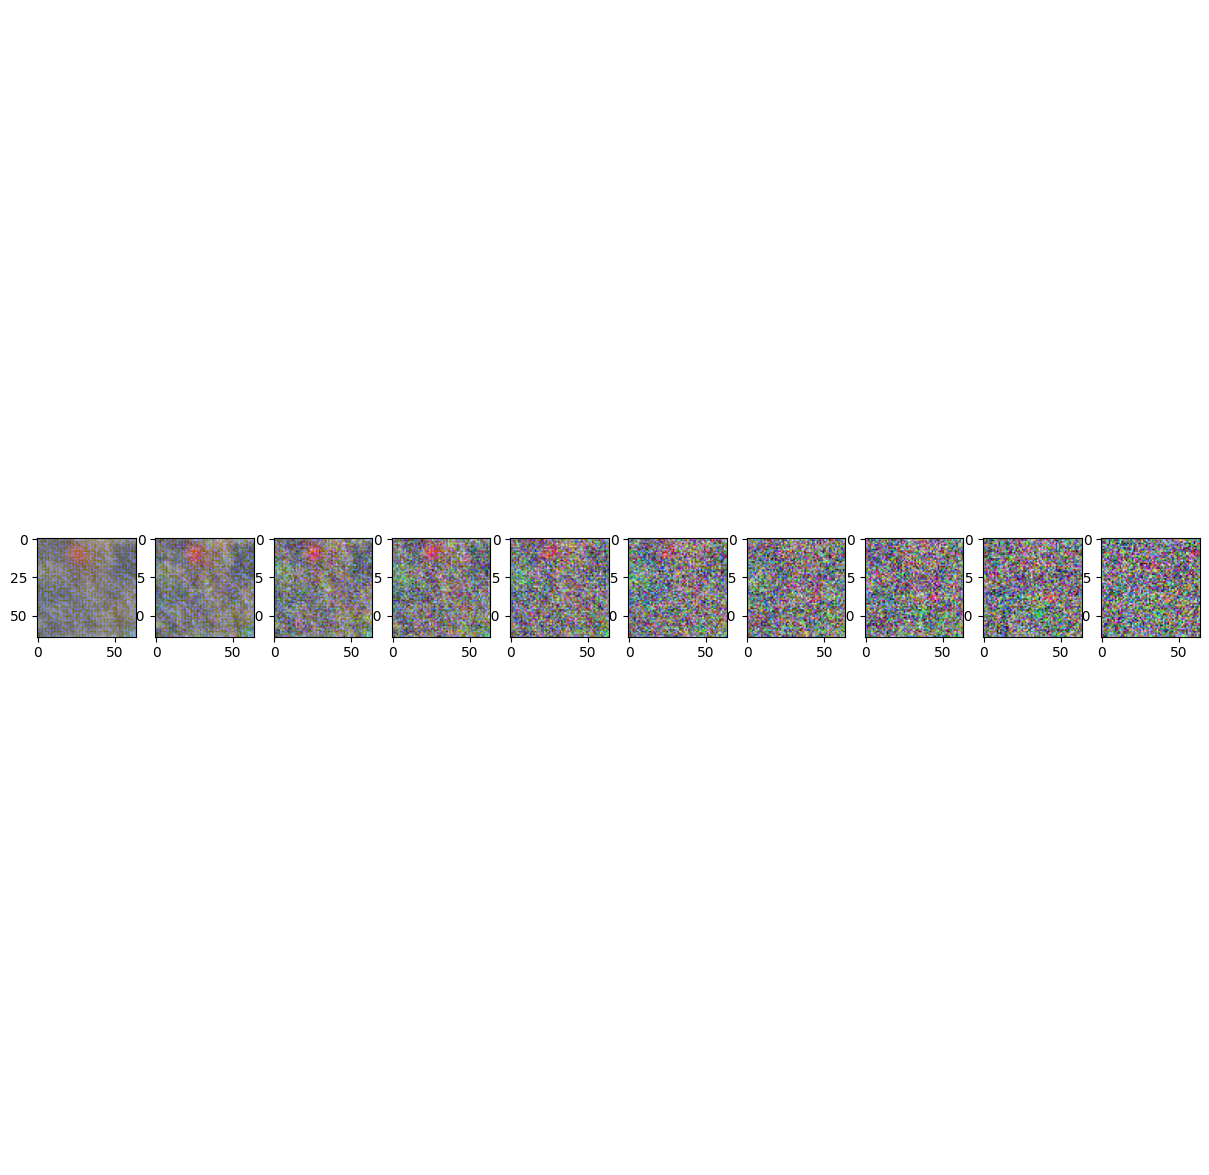

Epoch 1 | step 300 Loss: 0.14032498002052307 


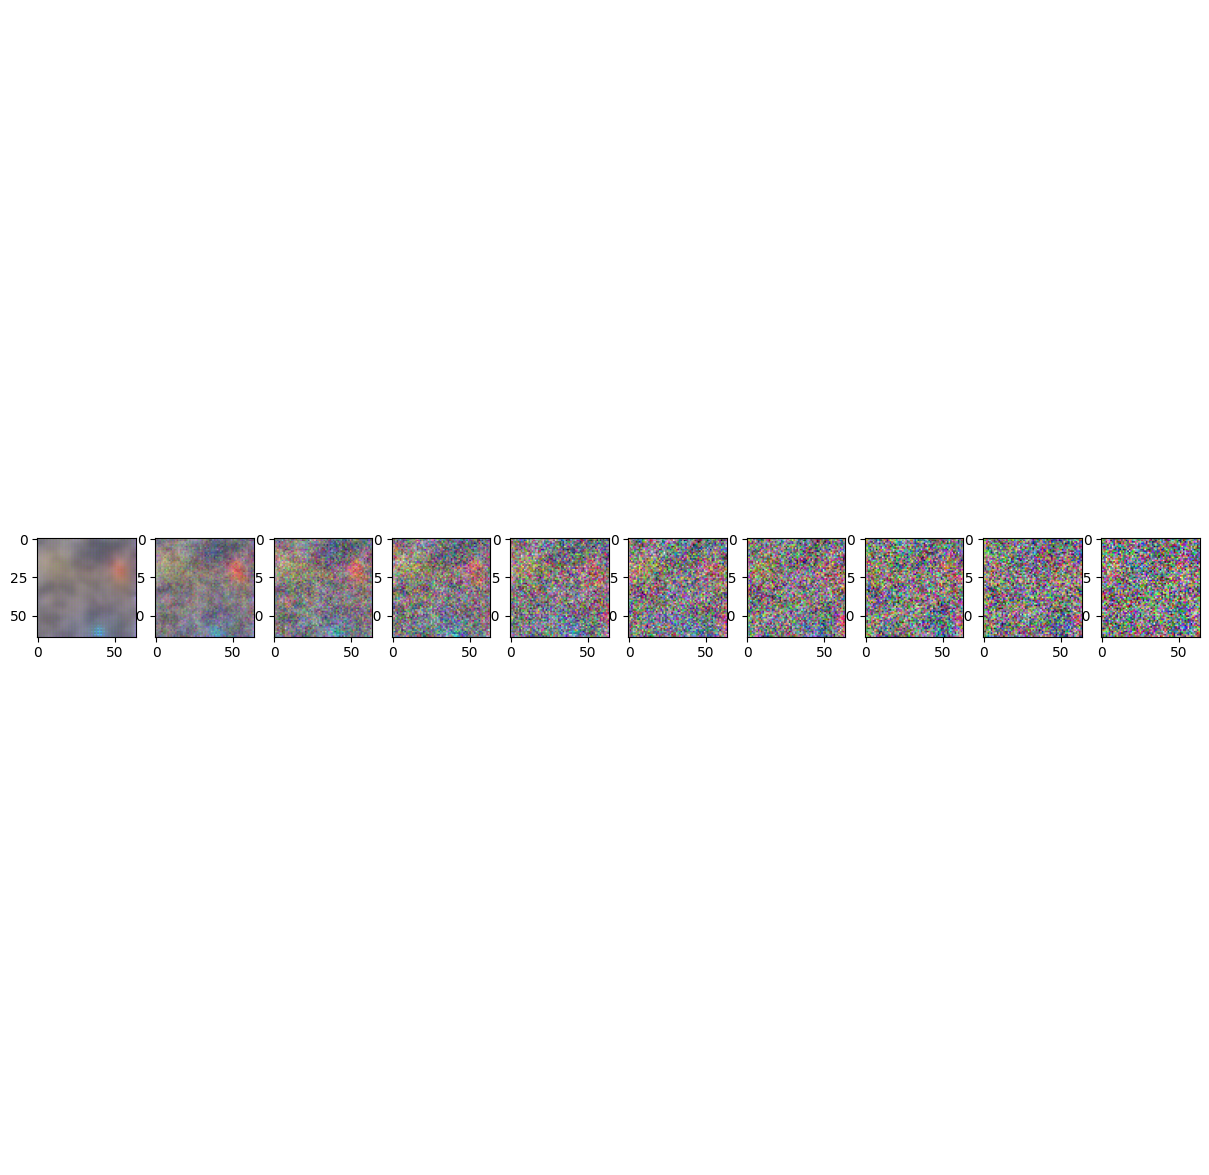

Epoch 2 | step 000 Loss: 0.12880347669124603 


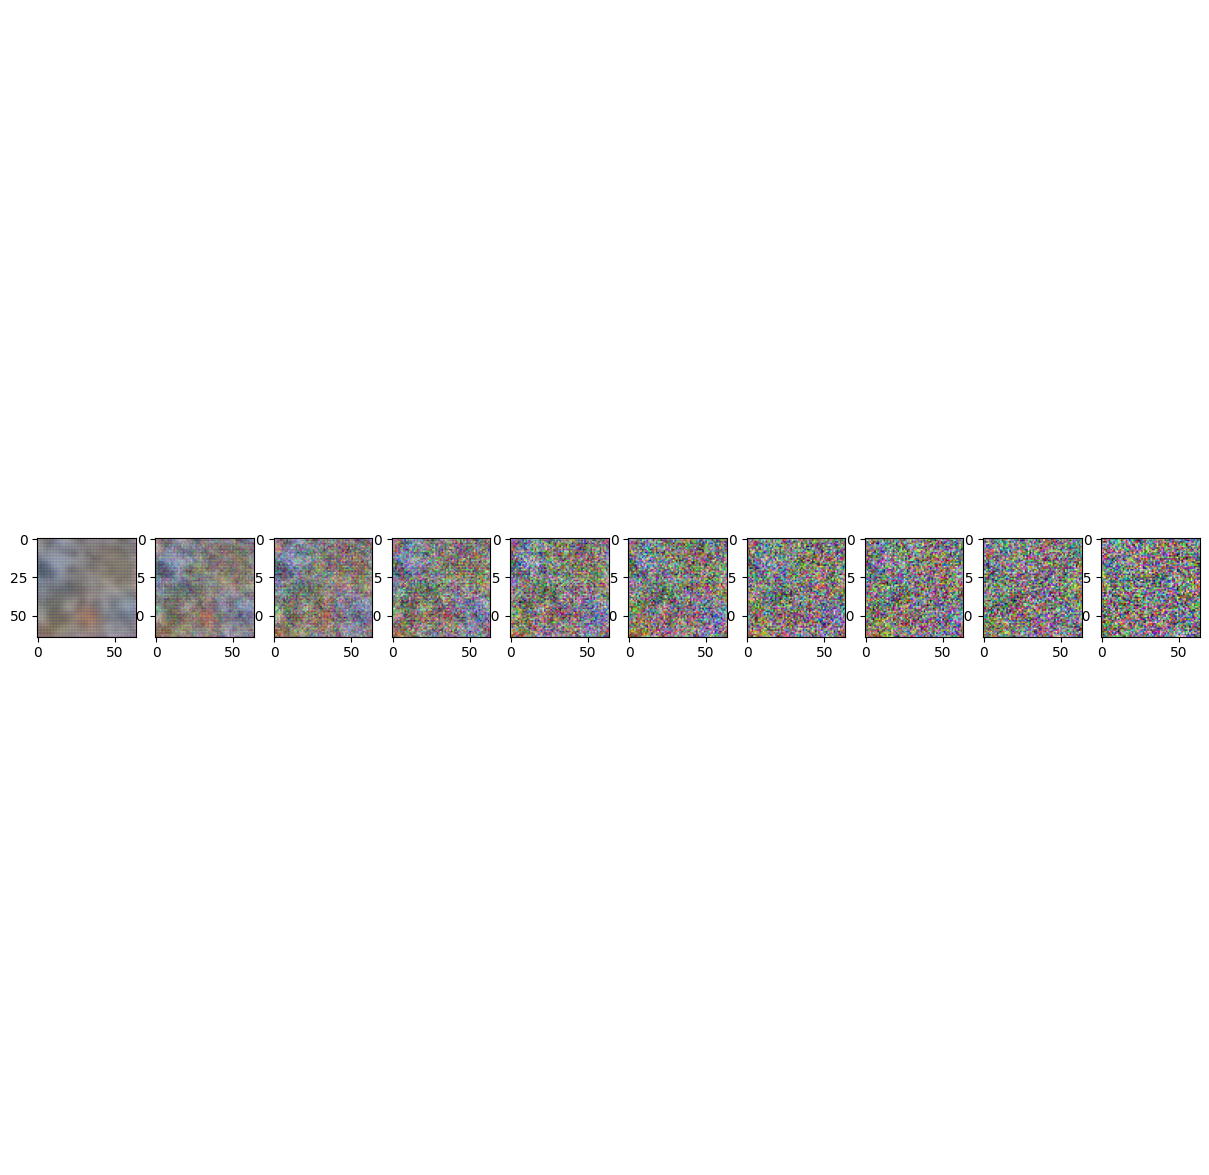

Epoch 2 | step 150 Loss: 0.11916445940732956 


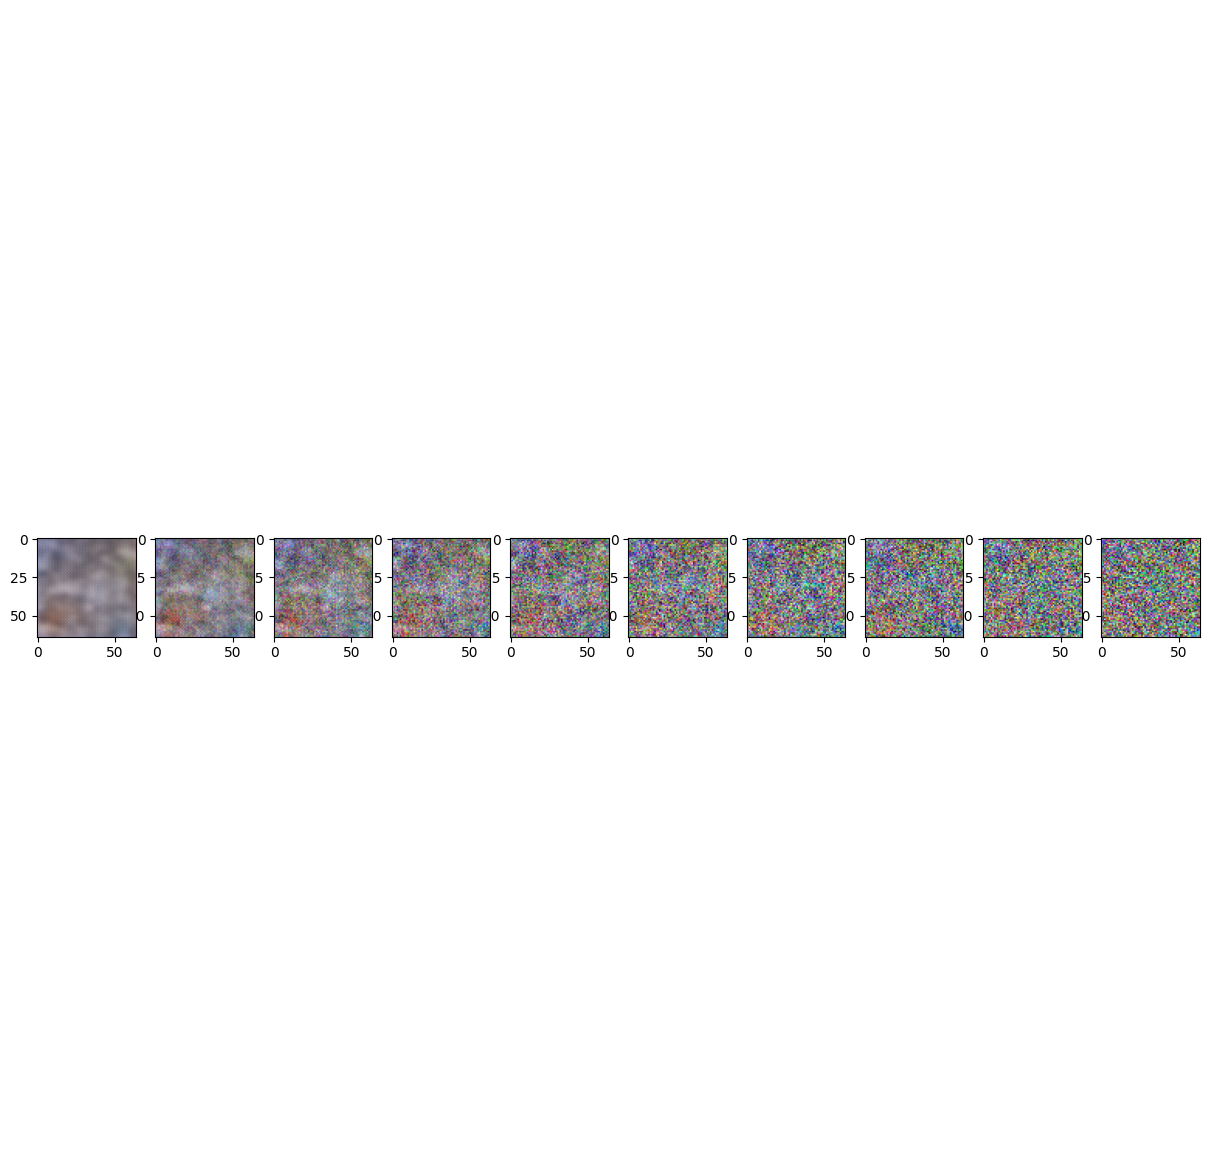

Epoch 2 | step 300 Loss: 0.12759575247764587 


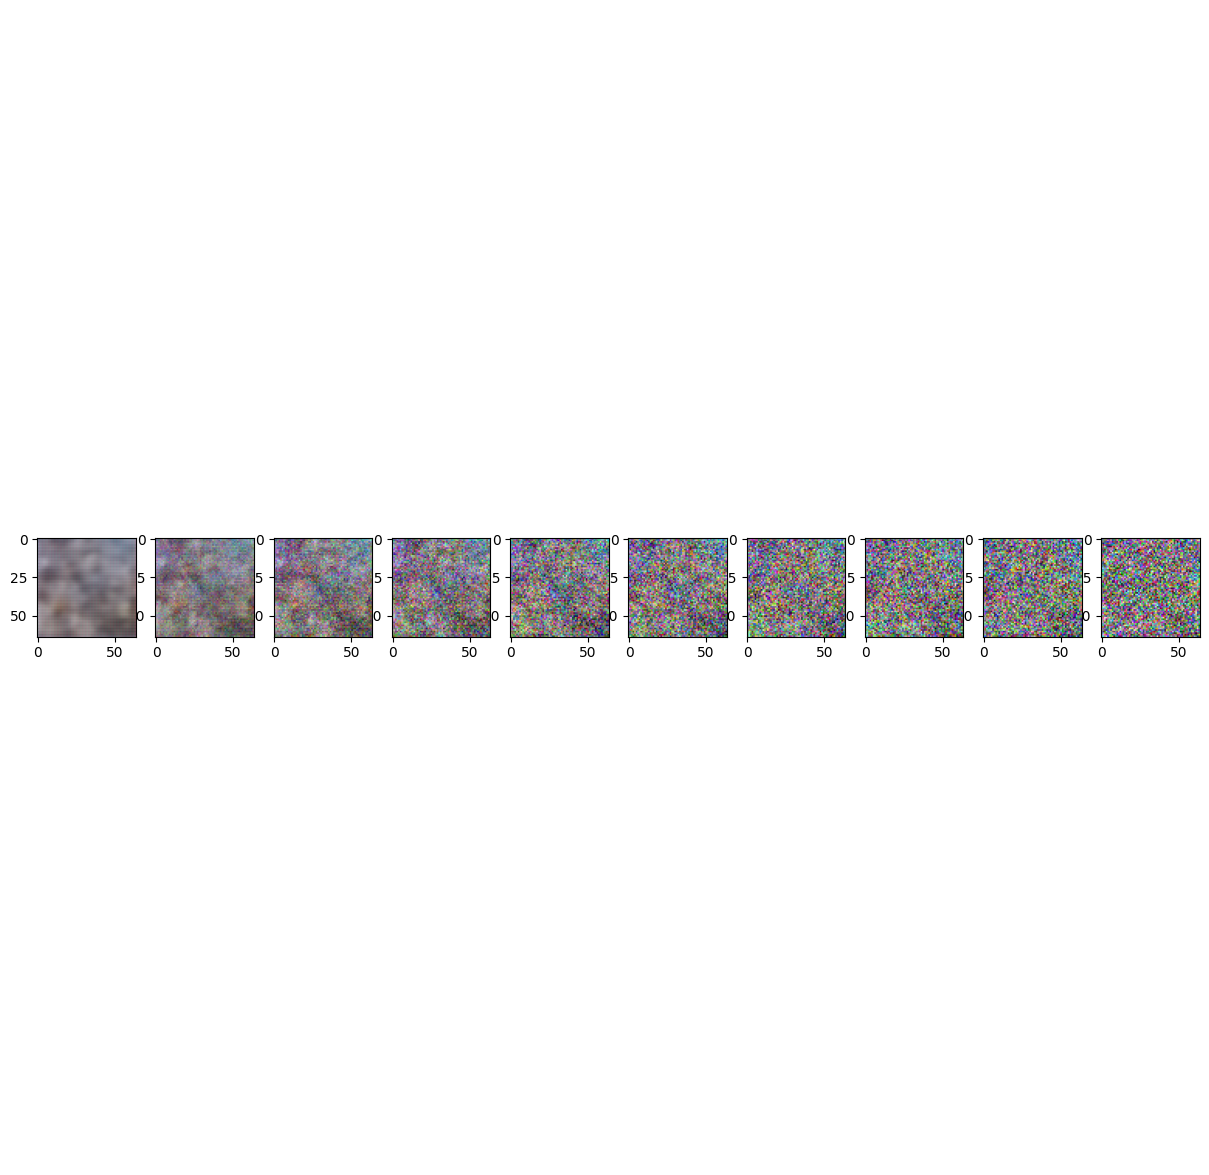

Epoch 3 | step 000 Loss: 0.12451761215925217 


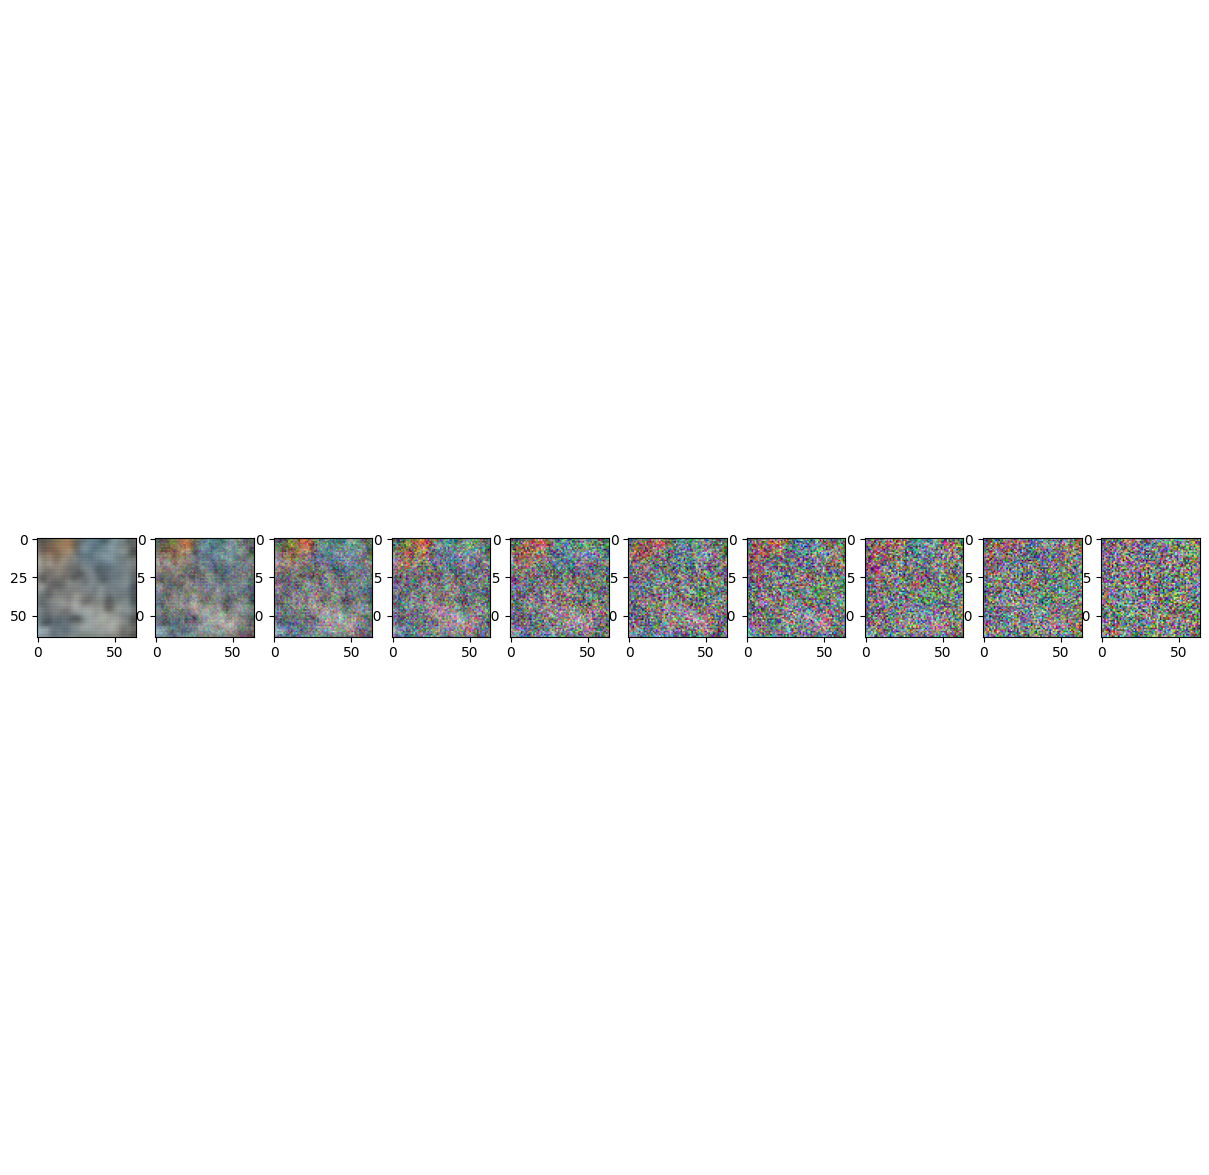

Epoch 3 | step 150 Loss: 0.12362663447856903 


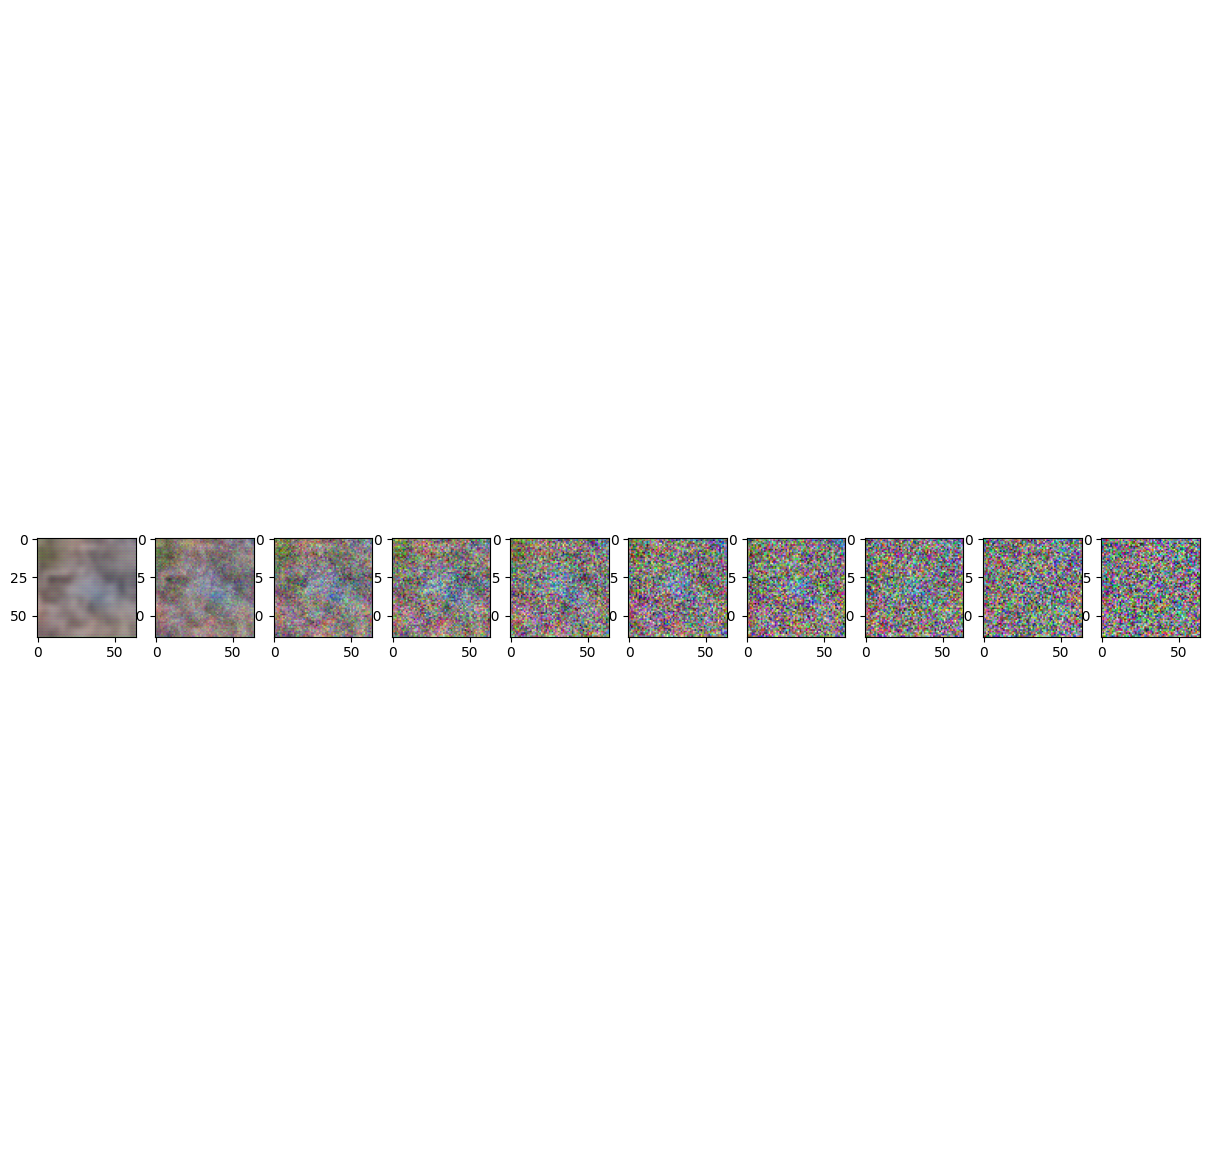

Epoch 3 | step 300 Loss: 0.1188521608710289 


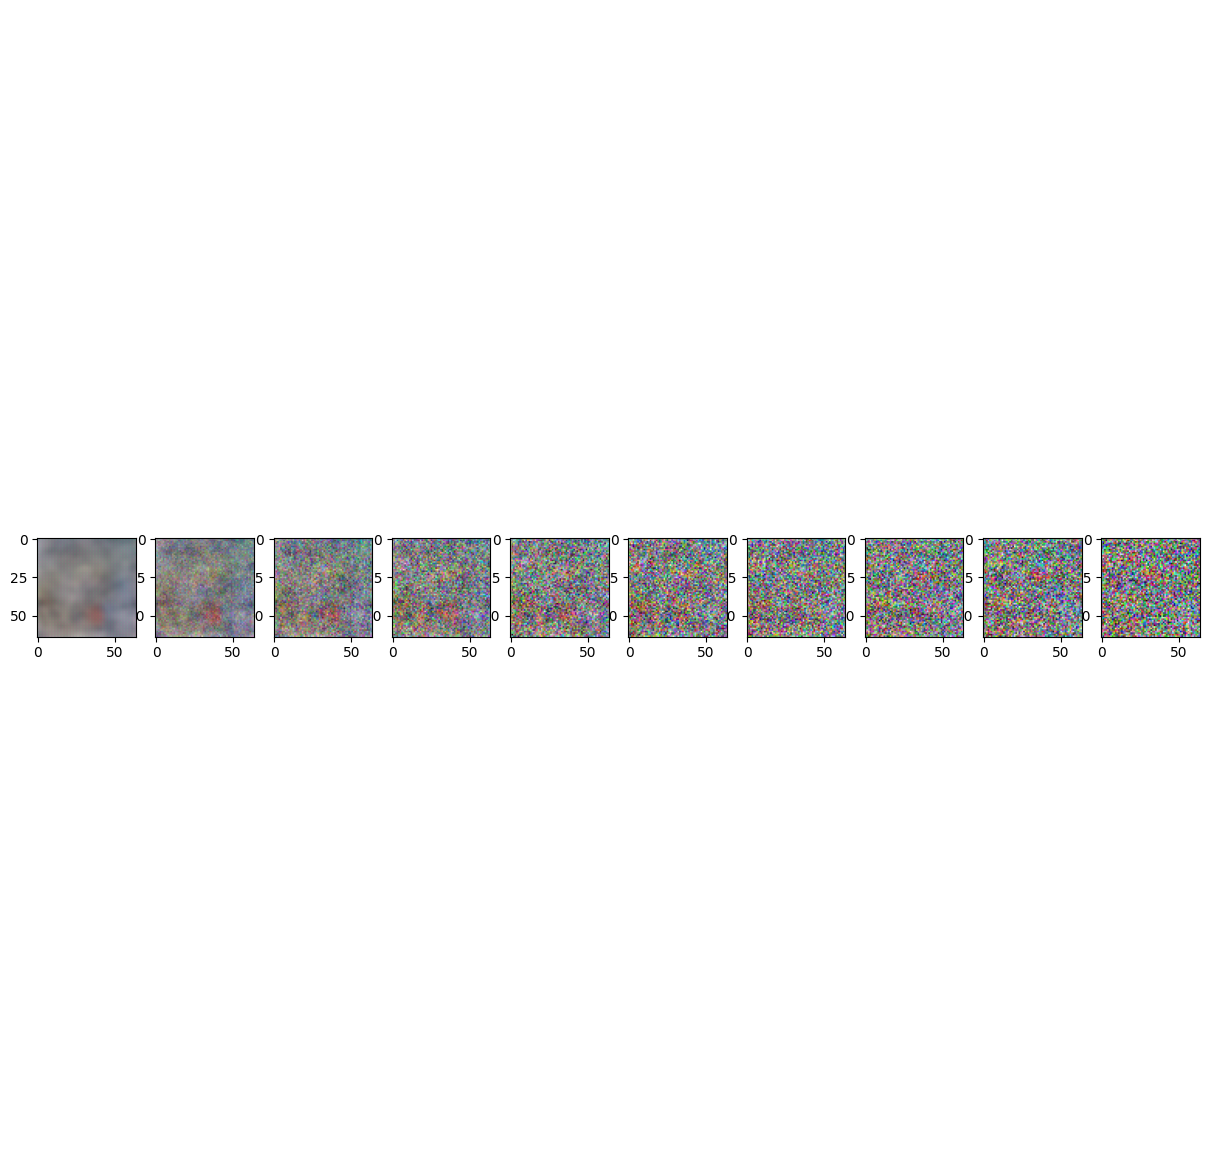

Epoch 4 | step 000 Loss: 0.12468590587377548 


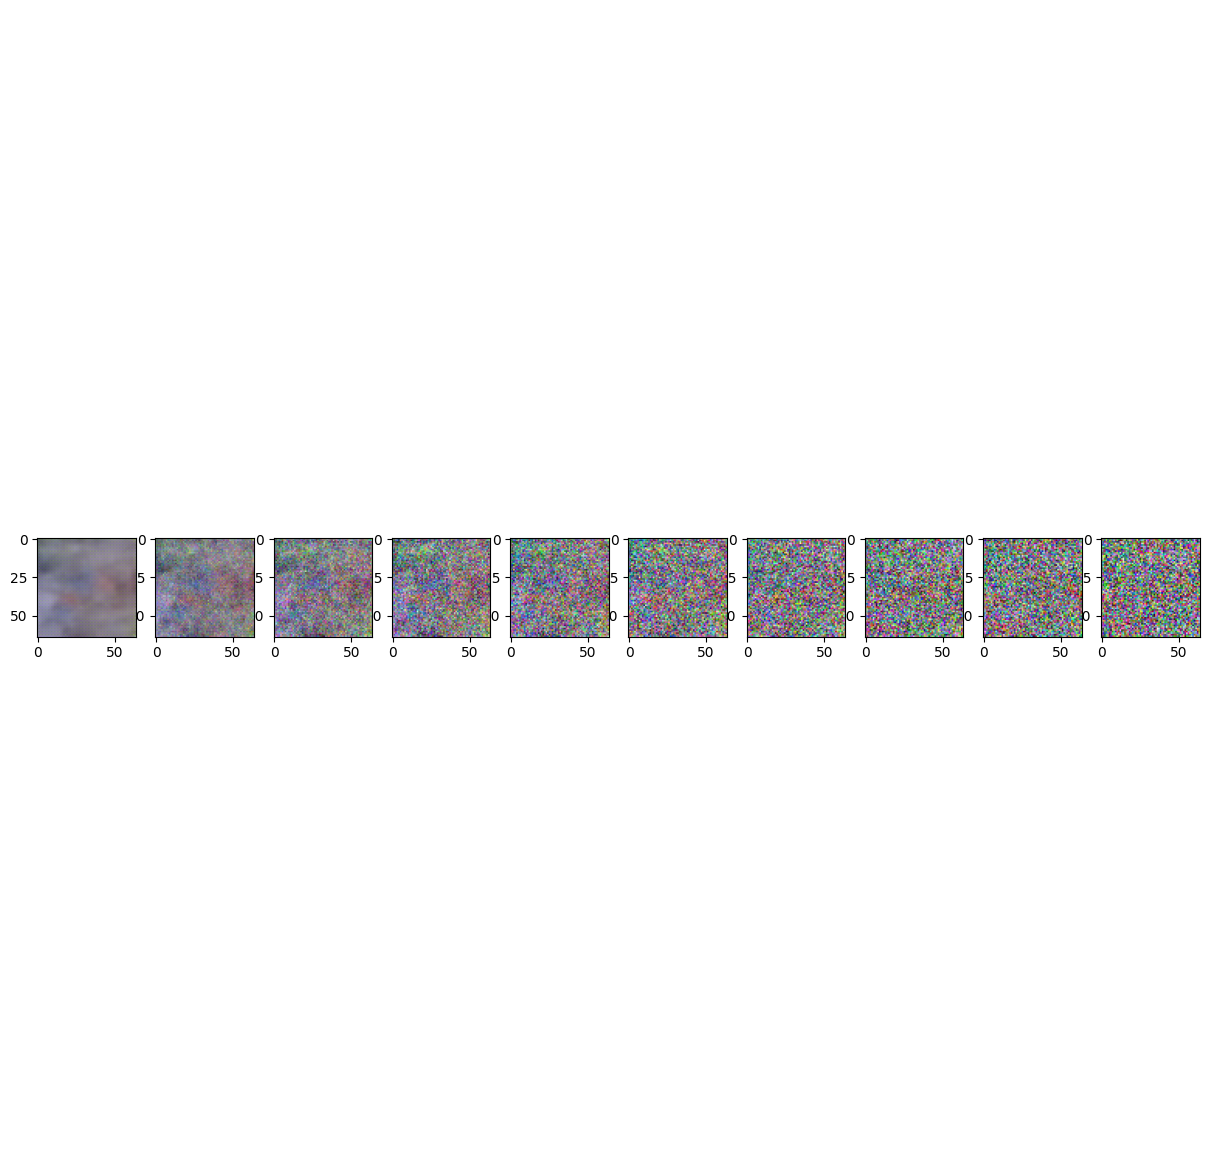

Epoch 4 | step 150 Loss: 0.11880310624837875 


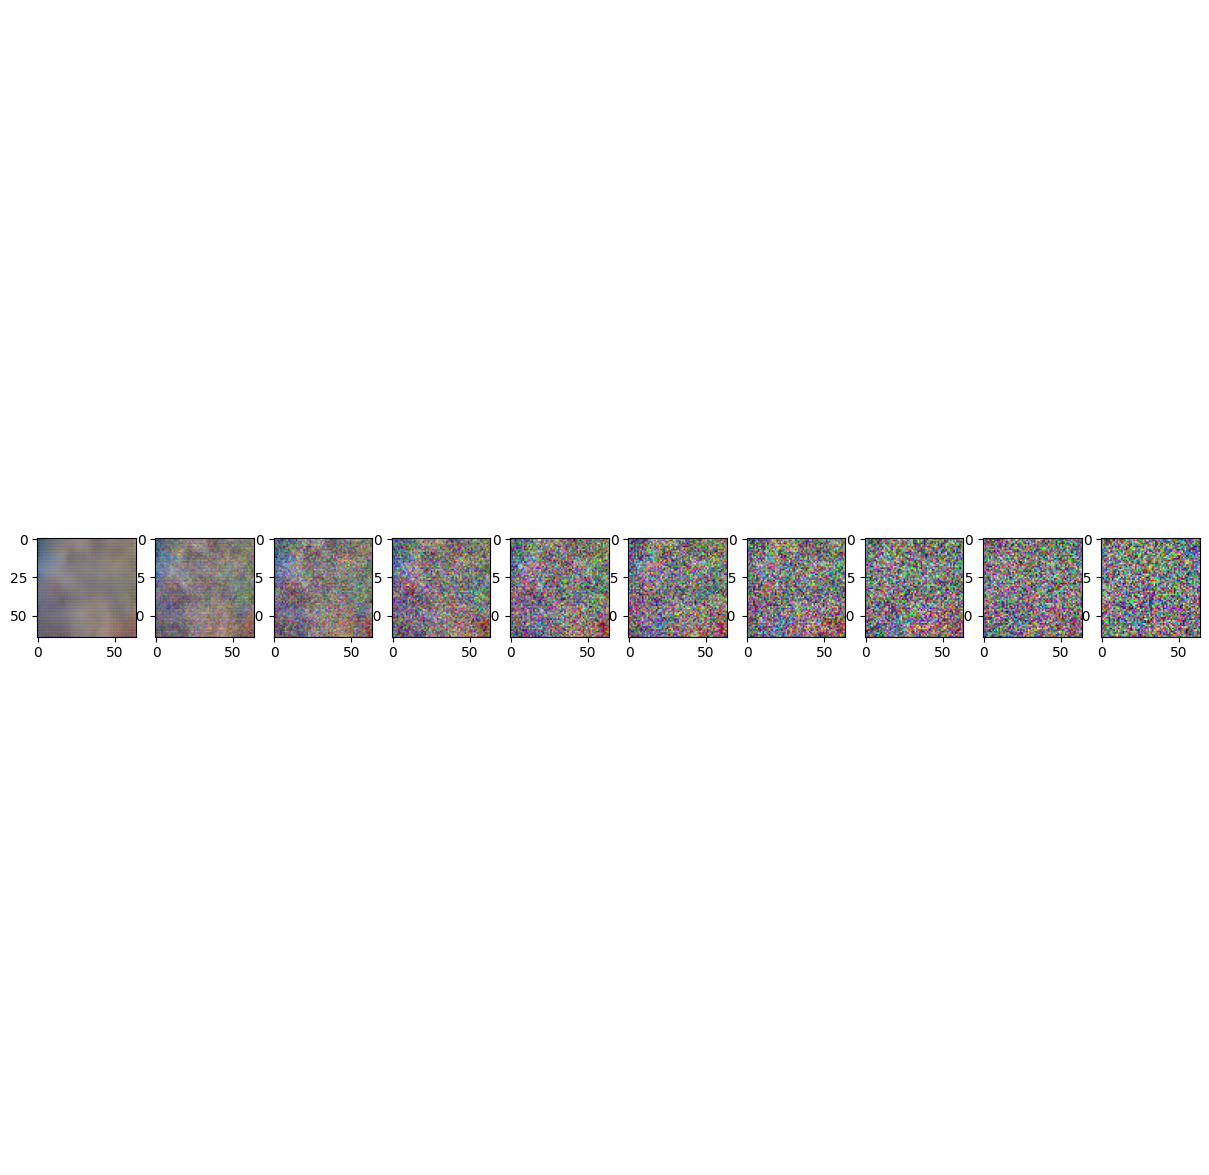

Epoch 4 | step 300 Loss: 0.11307957023382187 


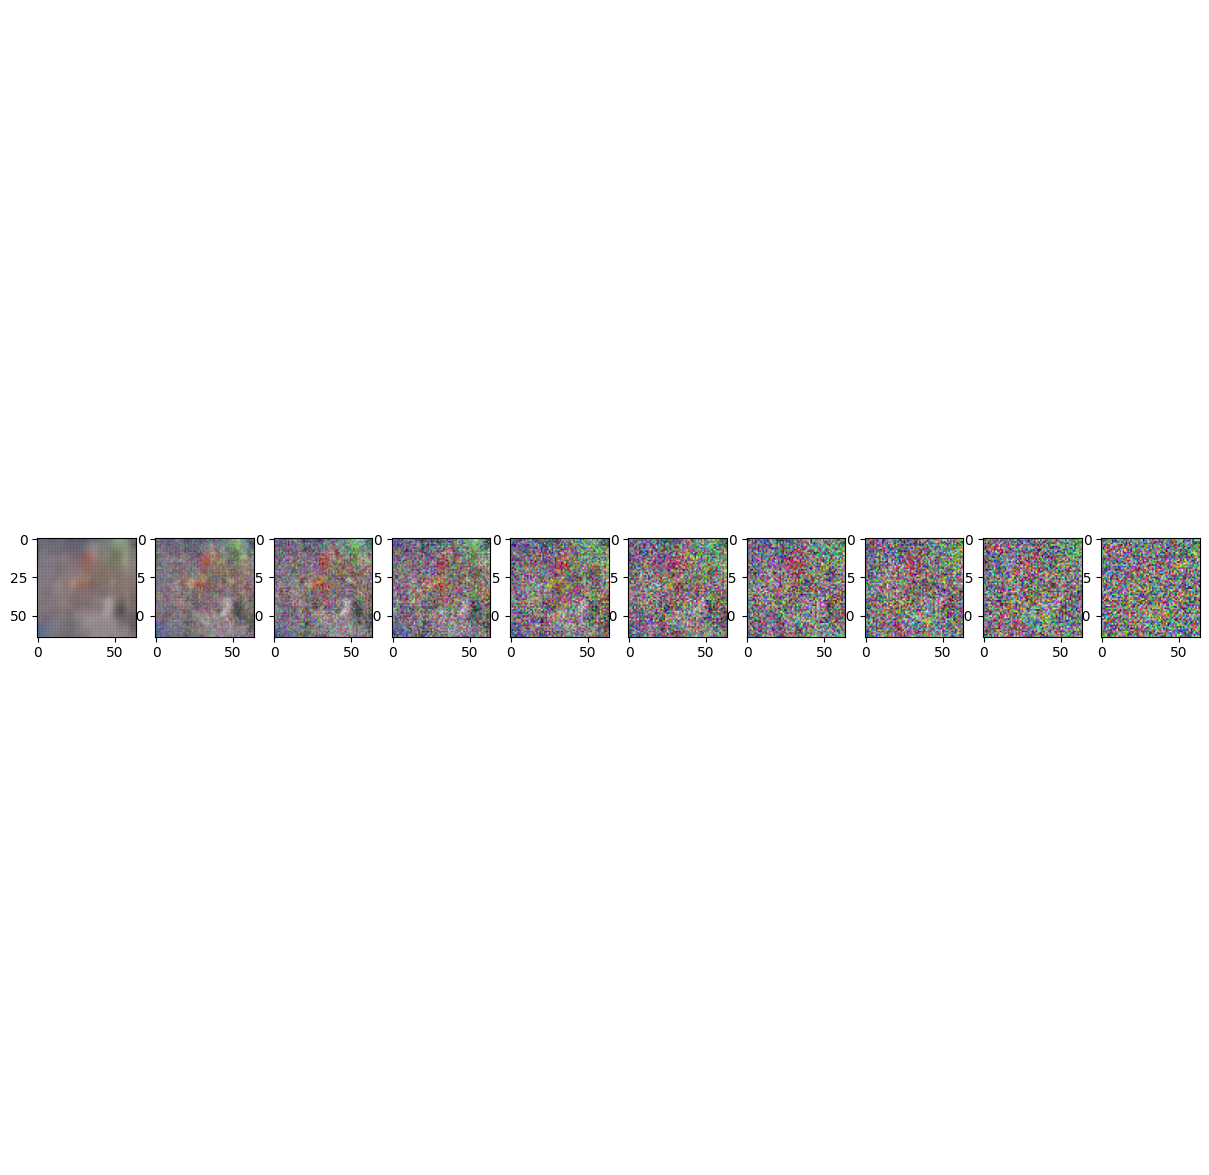

In [ ]:
## training loop
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 1 == 0 and step % 150 == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [18]:
# model(x_noisy, t)

NameError: name 'x_noisy' is not defined

In [12]:
model.save("/content/drive/MyDrive/Research Work/mlsa/DDPM/model.pth")

AttributeError: 'SimpleUnet' object has no attribute 'save'

In [17]:
# # prompt: save the weights in the SimpleUnet model
import os
# os.mkdir("/content/drive/MyDrive/Research Work/mlsa/DDPM")
torch.save(model.state_dict(), '/content/drive/MyDrive/Research Work/mlsa/DDPM/model_weights_attn.pth')

In [20]:
import torch
from torchvision.utils import save_image
model.eval()

SimpleUnet(
  (time_mlp): Sequential(
    (0): PositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tr

In [40]:
# model2 = SimpleUnet.load_pretrained("/content/drive/MyDrive/Research Work/mlsa/DDPM/model_weights.pth")
model2 = SimpleUnet()
model2.load_state_dict(torch.load("/content/drive/MyDrive/Research Work/mlsa/DDPM/model_weights.pth"))
model2.eval()

<ipython-input-40-9d7cd077738f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("/content/drive/MyDrive/Research Work/mlsa/DDPM/model_weig

SimpleUnet(
  (time_mlp): Sequential(
    (0): PositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tr

In [41]:
# Generate random Gaussian noise
num_samples = 8  # Number of images to generate
image_size = (3, 32, 32)  # Example for CIFAR10
noise = torch.randn(num_samples, *image_size).to("cuda")

model2.to("cuda")
# Generate images by denoising
with torch.no_grad():
    generated_images = model2.sample(noise)

# Save the generated images
save_image(generated_images, "generated_images.png", nrow=4, normalize=True)


cuda:0


RuntimeError: Boolean value of Tensor with more than one value is ambiguous